# **Disciplina CAT010** - Aplicações dos Satélites em Ciências Atmosféricas


---

## **Aula Prática 5 - Parte 2:** $\underline{Plotando\ e\ Analisando\ Relâmpagos\ Estimados\ pelo\ Satélite\ GOES-16}$
---
**OBJETIVO:** Nesta aula prática aprenderemos como trabalhar com dados de relâmpagos estimado por satélite. Para isto usaremos os dados do sensor [Geostationary Lightning Mapper (GLM)](https://space.oscar.wmo.int/instruments/view/glm) abordo do satélite [Geostationary Operational Environmental Satellite - 16 (GOES-16)](https://space.oscar.wmo.int/satellites/view/goes_16). O objetivo dessa **Parte 2** é aprender como plotar e analisar os dados a cada 5 min do GLM para toda área de abrangência do satélite GOES-16.

---


**DADOS DE ENTRADA**: Arquivos de relâmpagos.

1. $\underline{Dados\ de\ Relâmpagos}$: sensor GLM do satélite GOES-16
- **Tipo do dado:** matriz de 1664 linhas x 1664 colunas  
- **Formato do dado:** arquivo NETCDF
- **Nome do arquivo:** S11635949_202201141500.nc
- **Fonte dos dados:** FTP do [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/)


---

**DADOS DE SAÍDA:** .
- **Tipo do dado:** Figura
- **Formato do dado:** arquivos JPG
- **Imagens geradas:**
    1. Fig_1_goes16_flash_mapa_periodo.jpg
    2. Fig_2_goes16_flash_serie_temporal_5min.jpg
    3. Fig_3_goes16_flash_mapa_hora.jpg
    4. Fig_4_goes16_flash_serie_temporal_hora.jpg
    5. Fig_5_goes16_flash_mapa_dia.jpg
    6. Fig_6_goes16_flash_serie_temporal_dia.jpg

---

**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:
1.   Instalação de bibliotecas
2.   Monta o google drive
3.   Define o caminho do google drive
4.   Importação das bibliotecas
5.   Carrega o GeoBR
6.   Define funções
7.   Conhecendo os dados de relâmpagos a cada 5 min do sensor GLM
8.   Combinando imagem de satélite com flashes: América do Sul
9.   Lendo vários arquivos do GLM que estão com frequência temporal de 5 min


---
**OBSERVAÇÕES IMPORTANTES**:
1. Fazer mudanças, veja em: **### >>> MUDANÇAS AQUI <<< ###**
    - 1. Caminho do seu drive

---
- **Realizado por:** Enrique V. Mattos - 18/05/2022
- **Atualizado por:** Enrique V. Mattos - 08/11/2023


---


# **1° Passo:** Instalando as bibliotecas

In [ ]:
# Instalando o proplot (usado para gerar Mapas também)
!pip install -q proplot

# Instalando o cartopy (usado para gerar Mapas)
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical

Chegando aqui, será necessário fazer a **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

In [7]:
# Instalando a biblioteca Salem
!pip install rasterio -q
!pip install pyproj -q
!pip install geopandas -q
!pip install salem -q
!pip install descartes -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00


# **2° Passo:** Montando drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **3° Passo:** Caminho do diretório

- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula: `alterar aqui`

In [66]:
dir = '/content/drive/MyDrive/00_DISPONIBILIZAÇÃO_DE_AULAS/2_SEGUNDO_SEMESTRE/CAT010 - APLICAÇÕES DOS SATÉLITES EM CIÊNCIAS ATMOSFÉRICAS/AULAS/CAT010 - PYTHON PARA SATÉLITES METEOROLÓGICOS/AULA_05_RELAMPAGOS/'

- **Criando a pasta de saída ("output")**

In [67]:
import os
os.makedirs(f'{dir}output', exist_ok=True)

# **4° Passo:** Importando as bibliotecas

In [8]:
import proplot as pplt
import time as t
import glob
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import os
from time import process_time
import calendar
import salem
import xarray as xr
import pandas as pd

from datetime import timedelta, date, datetime
import imageio    # Python interface to read and write a wide range of image data

import sys
sys.path.append(f'{dir}')
from cpt_convert import loadCPT

from matplotlib.colors import LinearSegmentedColormap # interpolação linear para as cores dos mapas
from matplotlib import cm                           # Colormap handling utilities

import warnings
warnings.filterwarnings("ignore")

# **5° Passo:** Shapefiles
- Iremos utilizar os arquivos shapefiles do território brasileiro. Os dados serão baixados direto do meu [GitHub](https://github.com/evmpython/shapefile).

In [9]:
# url
url = 'https://github.com/evmpython/shapefile/raw/main/'

# caminho completo do arquivo. Exemplo: !wget https://github.com/evmpython/shapefile/raw/main/BR_UF_2019.shp
file1 = f'{url}BR_UF_2019.cpg'
file2 = f'{url}BR_UF_2019.dbf'
file3 = f'{url}BR_UF_2019.prj'
file4 = f'{url}BR_UF_2019.shp'
file5 = f'{url}BR_UF_2019.shx'

# baixa o shapefile
!wget -c {file1}
!wget -c {file2}
!wget -c {file3}
!wget -c {file4}
!wget -c {file5}

# lendo shapefile de todos Estados do Brasil
estados = salem.read_shapefile('/content/BR_UF_2019.shp')
estados

--2023-11-08 18:48:08--  https://github.com/evmpython/shapefile/raw/main/BR_UF_2019.cpg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/evmpython/shapefile/main/BR_UF_2019.cpg [following]
--2023-11-08 18:48:08--  https://raw.githubusercontent.com/evmpython/shapefile/main/BR_UF_2019.cpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2023-11-08 18:48:08--  https://github.com/evmpython/shapefile/raw/main/BR_UF_2019.dbf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... c

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,min_x,max_x,min_y,max_y
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",-66.810253,-59.774357,-13.693700,-7.975868
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828...",-73.990450,-66.623754,-11.145561,-7.111824
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620...",-73.801558,-56.097558,-9.818046,2.246631
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416...",-64.825254,-58.886884,-1.580633,5.271841
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ...",-58.898328,-46.061425,-9.841153,2.591027
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2...",-54.876250,-49.875682,-1.236176,4.508817
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23163 -5.94614, -48.23011 -5.938...",-50.742064,-45.699265,-13.467713,-5.168381
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.53830 -2.02124, -44.53742 ...",-48.755151,-41.795884,-10.261765,-1.049328
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91539 -6.64607, -42.91645 -6.644...",-46.028207,-40.370510,-10.928756,-2.749753
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017...",-41.423518,-37.252659,-7.858182,-2.784323


# **6° Passo:** Definindo funções

**Função que baixa os dados do GLM que possuem frequência temporal de 5 min no ftp do CPTEC**

In [10]:
def download_GLM5min_CPTEC(ano, mes, dia, hor, min):

    print('.... Baixando dado ===>', 'DATA=', ano, mes, dia, hor, min)

    # caminho do ftp do cptec
    ftp_cptec_glm_5min = 'http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/'

    # código do produto
    codigo_produto = 'S11635949'

    # nome do arquivo
    file_glm5min_cptec =  f'{ftp_cptec_glm_5min}{ano}/{mes}/{codigo_produto}_{ano}{mes}{dia}{hor}{min}.nc' # S11635949_202209010000.nc

    # baixando a imagem de satélite
    !wget -c {file_glm5min_cptec}

    # local da imagem que foi baixada
    file_glm_download = f'/content/{codigo_produto}_{ano}{mes}{dia}{hor}{min}.nc'

    return file_glm_download

# **PARTE 1)**: Conhecendo os dados de relâmpagos a cada **5 min** do sensor GLM

##**a) nome do arquivo**

---
1. **Descrição:** São os dados gerados pelo CPTEC.
---
2. **Onde baixar os dados:** Os aquivos de densidade de relâmpagos do sensor GLM abordo do satélite GOES-16 podem ser baixados do FTP do CPTEC.
---
   1. **FORMA 1:** Os dados de densidade de relâmpagos do satélite GOES-16 são disponibilizados pelo CPTEC nesse [link](http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/).

- Formato dos arquivos: Netcdf. Os dados estão como arrays tridimensionais.
- Como baixar pelo Colab: !wget ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/2020/01/S11635949_202001010000.nc

- Exemplos dos arquivos:
    - S11635949_202201141500.nc
    - S11635949_202201141505.nc
    - S11635949_202201141510.nc
    - S11635949_202201141515.nc
    - S11635949_202201141520.nc
    - S11635949_202201141525.nc
    - S11635949_202201141530.nc
    - S11635949_202201141535.nc
    - S11635949_202201141540.nc
    - S11635949_202201141545.nc
    - S11635949_202201141550.nc
    - S11635949_202201141555.nc
    - S11635949_202201141600.nc


- Informações que constam nos nomes dos arquivos:  
    - **S11635949**: Identificador do produto no banco do CPTEC
    -**202001010000**: ano (2020), mês (01), dia (01), hora (00), minuto (00)
---

In [69]:
# nome do arquivo
file_5min = 'S11635949_202201141500.nc'

##**b) leitura do arquivo**

In [12]:
# leitura do arquivo
ds_5min = xr.open_dataset(f'{dir}input/5min/{file_5min}')

In [13]:
# exibe os dados
ds_5min

<xarray.Dataset>
Dimensions:         (time: 1, lat: 1664, lon: 1664)
Coordinates:
  * time            (time) datetime64[ns] 2022-01-14T15:00:00
  * lat             (lat) float32 -66.56 -66.48 -66.4 ... 66.32 66.4 66.48
  * lon             (lon) float32 -141.6 -141.5 -141.4 ... -8.68 -8.6 -8.52
Data variables:
    spatial_ref     int32 ...
    event           (time, lat, lon) float32 ...
    flash           (time, lat, lon) float32 ...
    group           (time, lat, lon) float32 ...
    event_energy    (time, lat, lon) float32 ...
    flash_energy    (time, lat, lon) float32 ...
    group_energy    (time, lat, lon) float32 ...
    duration_flash  (time, lat, lon) float32 ...
    flash_count     int16 ...
    group_count     int16 ...
    event_count     int16 ...
Attributes:
    description:  Center for Weather Forecasting and Climate Studies/INPE
    history:      Create in Fri Jan 14 15:09:29 2022
    source:       GLM Lightning Accumulated (5 minutes) - GOES 16 ['OR_GLM-L2...

##**c) exibindo os dados**

In [14]:
# formato dos dados de flash
ds_5min['flash'].shape

(1, 1664, 1664)

In [15]:
# dados de flash
ds_5min['flash']

<xarray.DataArray 'flash' (time: 1, lat: 1664, lon: 1664)>
[2768896 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2022-01-14T15:00:00
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Attributes:
    units:                                                  flash/5minutes/64km2
    standard_name:                                          GLM Flash Centroi...
    valid_range:                                            [    0. 10000.]
    lat_field_of_view:                                      [ 66.56 -66.56]
    lon_field_of_view:                                      [ 66.56 -66.56]
    keywords:                                               lightning/goes/gl...
    FillValue:                                              0
    goes_imager_projection_longitude_of_projection_origin:  -89.5

In [16]:
# latitudes
ds_5min['lat']

<xarray.DataArray 'lat' (lat: 1664)>
array([-66.56    , -66.479996, -66.399994, ...,  66.32    ,  66.4     ,
        66.48    ], dtype=float32)
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
Attributes:
    units:    degree_north

In [17]:
# longitudes
ds_5min['lon']

<xarray.DataArray 'lon' (lon: 1664)>
array([-141.56    , -141.48    , -141.4     , ...,   -8.679997,   -8.599998,
         -8.519998], dtype=float32)
Coordinates:
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Attributes:
    units:    degree_east

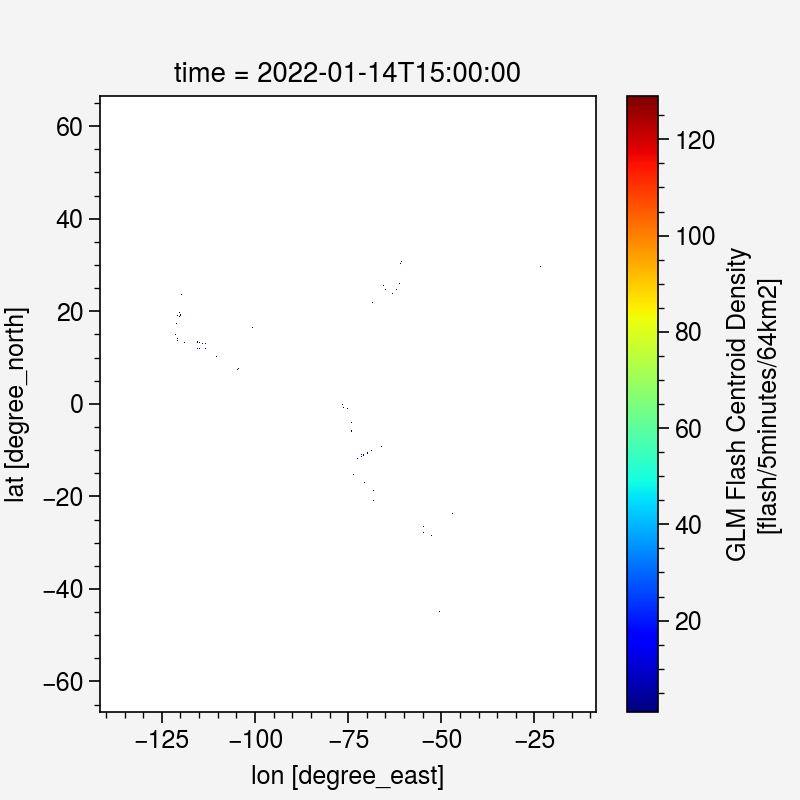

In [18]:
# mapa simples
ds_5min['flash'][0, :, :].plot(cmap='jet')

# **PARTE 2)**: Lendo vários arquivos do GLM que estão com frequência temporal de **5 min**

##**a) Definindo data/horário**

In [70]:
# data INICIAL
anoi, mesi, diai, hori, mini = 2021, 1, 3, 0, 0 # ano, mês, dia, hora e minuto inicial do período

# data FINAL
anof, mesf, diaf, horf, minf = 2021, 1, 5, 23, 55 # ano, mês, dia, hora e minuto final do período

In [20]:
# mostra na tela o período sendo processado
print('Data Inicial---->>>>', 'Ano=', anoi, '/Mês=', mesi,'/Dia=', diai, '/Hora=', hori, '/Minuto=', mini)
print('Data Final---->>>>', 'Ano=', anof, '/Mês=', mesf, '/Dia=', diaf, '/Hora=', horf, '/Minuto=', minf)

Data Inicial---->>>> Ano= 2021 /Mês= 1 /Dia= 3 /Hora= 0 /Minuto= 0
Data Final---->>>> Ano= 2021 /Mês= 1 /Dia= 5 /Hora= 23 /Minuto= 55


##**b) Download dos dados do GLM**
- 27 min para baixar todos os dados

In [21]:
# Inicia o contador de tempo
start_time = t.time()

# Data desejada
date_in = datetime(anoi, mesi, diai, hori, mini)  # 2022-02-02 00:00:00
date_ini = date_in.strftime('%Y%m%d%H%M') # 20220202

date_en = datetime(anof, mesf, diaf, horf, minf)
date_end = date_en.strftime('%Y%m%d%H%M')

print('.... Processando Data ...:', date_ini, date_end, '\n')

# Download dos dados
files_imagens = []
for file in pd.date_range(date_ini, date_end, freq='5min'):

    # Extrai ano e mes
    data = file.strftime('%Y%m%d%H%M')
    ano = file.strftime('%Y')
    mes = file.strftime('%m')
    dia = file.strftime('%d')
    hor = file.strftime('%H')
    min = file.strftime('%M')

    # baixa imagem de satélite
    file_glm_download = download_GLM5min_CPTEC(ano, mes, dia, hor, min)

    # salva o nomes das imagens baixadas
    files_imagens.append(file_glm_download)

# Contabiliza o tempo para baixar os dados
print('\nTempo de download dos dados:', round((t.time() - start_time),2), 'segundos.')

A saída de streaming foi truncada nas últimas 5000 linhas.
Saving to: ‘S11635949_202101041315.nc’

S11635949_202101041 100%[===================>] 167.34K   130KB/s    in 1.3s    

2023-11-08 19:02:53 (130 KB/s) - ‘S11635949_202101041315.nc’ saved [171361/171361]

.... Baixando dado ===> DATA= 2021 01 04 13 20
--2023-11-08 19:02:53--  http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/2021/01/S11635949_202101041320.nc
Resolving ftp.cptec.inpe.br (ftp.cptec.inpe.br)... 150.163.192.38
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.192.38|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166919 (163K) [application/x-netcdf]
Saving to: ‘S11635949_202101041320.nc’

S11635949_202101041 100%[===================>] 163.01K   127KB/s    in 1.3s    

2023-11-08 19:02:55 (127 KB/s) - ‘S11635949_202101041320.nc’ saved [166919/166919]

.... Baixando dado ===> DATA= 2021 01 04 13 25
--2023-11-08 19:02:55--  http://ftp.cptec.inpe.br/goes/goes16/goes16_w

##**c) Leitura do dado**

In [22]:
# define a área de recorte. Nesse exemplo recortaremos os dados para região Sudeste do Brasil
lonmin_rec, lonmax_rec, latmin_rec, latmax_rec = -53.50, -39.50, -26.0, -14.0

In [23]:
# nomes dos arquivos
files = sorted(glob.glob('/content/S11635949_*nc'))

In [24]:
#files = files[0:-30]

In [25]:
# mostra a lista de arquivos que foi montada
files

['/content/S11635949_202101030000.nc',
 '/content/S11635949_202101030005.nc',
 '/content/S11635949_202101030010.nc',
 '/content/S11635949_202101030015.nc',
 '/content/S11635949_202101030025.nc',
 '/content/S11635949_202101030030.nc',
 '/content/S11635949_202101030035.nc',
 '/content/S11635949_202101030040.nc',
 '/content/S11635949_202101030045.nc',
 '/content/S11635949_202101030055.nc',
 '/content/S11635949_202101030100.nc',
 '/content/S11635949_202101030105.nc',
 '/content/S11635949_202101030110.nc',
 '/content/S11635949_202101030115.nc',
 '/content/S11635949_202101030120.nc',
 '/content/S11635949_202101030125.nc',
 '/content/S11635949_202101030130.nc',
 '/content/S11635949_202101030135.nc',
 '/content/S11635949_202101030140.nc',
 '/content/S11635949_202101030145.nc',
 '/content/S11635949_202101030150.nc',
 '/content/S11635949_202101030155.nc',
 '/content/S11635949_202101030200.nc',
 '/content/S11635949_202101030205.nc',
 '/content/S11635949_202101030210.nc',
 '/content/S11635949_2021

In [26]:
# mostra o nome do PRIMEIRO arquivo da lista
files[0]

'/content/S11635949_202101030000.nc'

In [27]:
# mostra o nome do ÚLTIMO arquivo da lista
files[-1]

'/content/S11635949_202101052355.nc'

In [28]:
# leitura do dado
glm_5min = xr.open_mfdataset(files, concat_dim='time', combine='nested') #.sel(lon=slice(lonmin_rec, lonmax_rec), lat=slice(latmin_rec, latmax_rec))

In [29]:
# mostra o dado
glm_5min

<xarray.Dataset>
Dimensions:         (time: 849, lat: 1664, lon: 1664)
Coordinates:
  * time            (time) datetime64[ns] 2021-01-03 ... 2021-01-05T23:55:00....
  * lat             (lat) float32 -66.56 -66.48 -66.4 ... 66.32 66.4 66.48
  * lon             (lon) float32 -141.6 -141.5 -141.4 ... -8.68 -8.6 -8.52
Data variables:
    spatial_ref     (time) int32 -2147483647 -2147483647 ... -2147483647
    event           (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>
    flash           (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>
    group           (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>
    event_energy    (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>
    flash_energy    (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>
    group_energy    (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>
    duration_flash  (time, lat, lon) float32 dask.array<chunksize=(1, 1664, 1664), meta=np.ndarray>
    flash_count     (time) int16 1310 1097 1219 1204 1126 ... 681 709 575 652
    group_count     (time) int16 2910 2516 2806 2716 ... 1421 1543 1267 1380
    event_count     (time) int16 8396 7541 8258 8257 ... 4957 5157 4301 4766
Attributes:
    description:  Center for Weather Forecasting and Climate Studies/INPE
    history:      Create in Sun Jan  3 00:10:43 2021
    source:       GLM Lightning Accumulated (5 minutes) - GOES 16 ['OR_GLM-L2...

In [30]:
# mostra os tempos
glm_5min['time'].values

array(['2021-01-03T00:00:00.000000000', '2021-01-03T00:04:59.999996000',
       '2021-01-03T00:10:00.000004000', '2021-01-03T00:15:00.000000000',
       '2021-01-03T00:25:00.000004000', '2021-01-03T00:30:00.000000000',
       '2021-01-03T00:34:59.999996000', '2021-01-03T00:40:00.000004000',
       '2021-01-03T00:45:00.000000000', '2021-01-03T00:55:00.000004000',
       '2021-01-03T01:00:00.000000000', '2021-01-03T01:04:59.999996000',
       '2021-01-03T01:10:00.000004000', '2021-01-03T01:15:00.000000000',
       '2021-01-03T01:19:59.999996000', '2021-01-03T01:25:00.000004000',
       '2021-01-03T01:30:00.000000000', '2021-01-03T01:34:59.999996000',
       '2021-01-03T01:40:00.000004000', '2021-01-03T01:45:00.000000000',
       '2021-01-03T01:49:59.999996000', '2021-01-03T01:55:00.000004000',
       '2021-01-03T02:00:00.000000000', '2021-01-03T02:04:59.999996000',
       '2021-01-03T02:10:00.000004000', '2021-01-03T02:15:00.000000000',
       '2021-01-03T02:25:00.000004000', '2021-01-03

##**d) Reamostra o dado somando os flashes de todos arquivos**

**Reamostra o dado**

In [31]:
# soma os dados no tempo
flash_total = glm_5min['flash'].sum(dim='time')

**Conhecendo os dados**

In [32]:
# mostra o dado que foi produzido
flash_total

<xarray.DataArray 'flash' (lat: 1664, lon: 1664)>
dask.array<sum-aggregate, shape=(1664, 1664), dtype=float32, chunksize=(1664, 1664), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52

**Produz um mapa simples da matriz de flash**

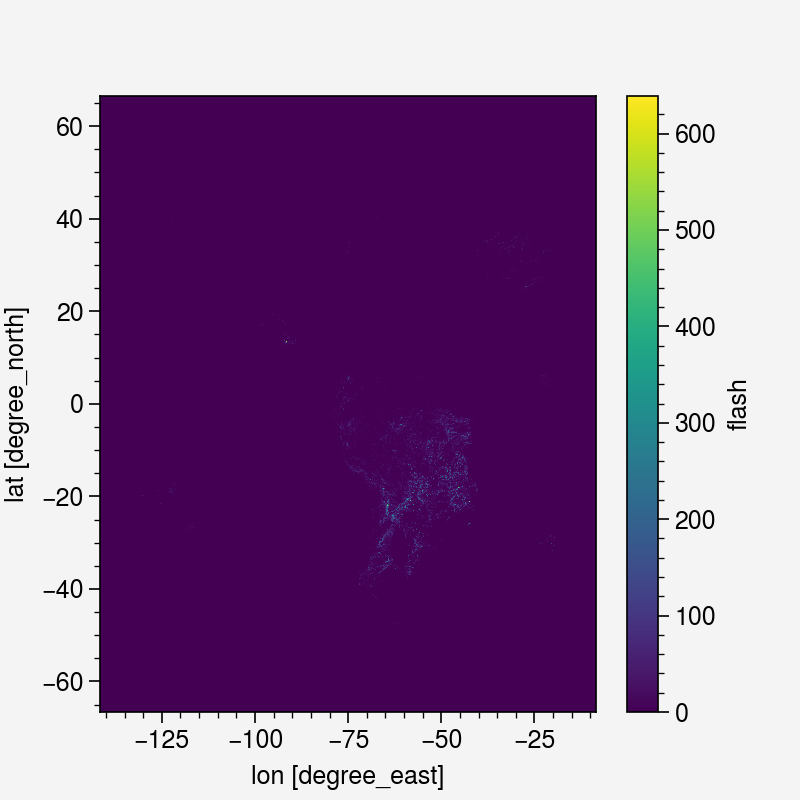

In [33]:
# produz um mapa simples da matriz de flash
flash_total.plot()

**Produz um mapa completo da matriz de flash**

In [34]:
# limites da figura
latmin, latmax, lonmin, lonmax = float(flash_total['lat'].min()), float(flash_total['lat'].max()), float(flash_total['lon'].min()), float(flash_total['lon'].max())

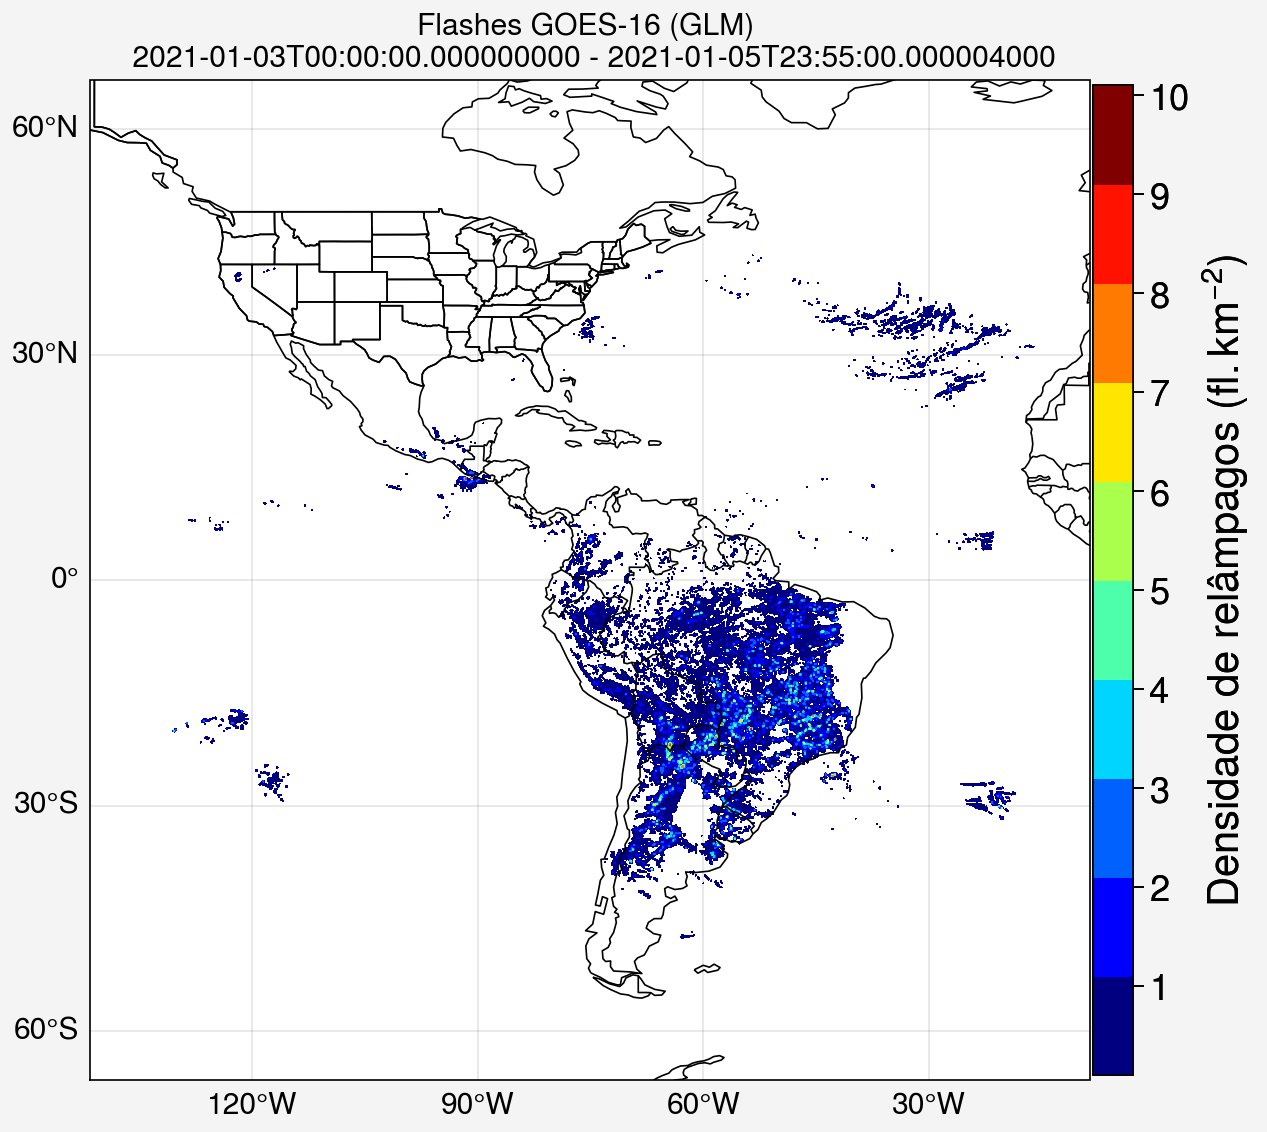

In [37]:
# cria moldura da figura
fig, ax = pplt.subplots(axwidth=5, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=True, borders=True, innerborders=True,
          labels=True, latlines=30, lonlines=30,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) \n {str(glm_5min["time"].values[0])} - {str(glm_5min["time"].values[-1])}',
          small='15px', large='15px')

# plota mapa. Aqui dividimos a matriz por 64 para termos a unidade em km2. Lembre-se que
# a matriz de flashes tem tamanho de 8 km x 8 km (ou seja, área de 64 km2).
map1 = ax.contourf(flash_total['lon'],
                   flash_total['lat'],
                   flash_total/64.,
                   cmap='jet',
                   levels=pplt.arange(0.1, 10., 1.0))

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2})$',
             ticks=1, ticklabelsize=13, labelsize=15,
             space=0.1, length=0.99)

# salva figura
fig.save(f'{dir}output/parte_2/Fig_1_goes16_flash_mapa_periodo.jpg', dpi=300)

**Produz gráfico com a série temporal de flash**

In [38]:
 # recorta os dados para região Sudeste
 glm_5min_recorte = glm_5min['flash'].sel(lon=slice(lonmin_rec, lonmax_rec), lat=slice(latmin_rec, latmax_rec))

In [39]:
# mostra o dado que foi recortado
glm_5min_recorte

<xarray.DataArray 'flash' (time: 849, lat: 150, lon: 175)>
dask.array<getitem, shape=(849, 150, 175), dtype=float32, chunksize=(1, 150, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-01-03 ... 2021-01-05T23:55:00.000004
  * lat      (lat) float32 -26.0 -25.92 -25.84 -25.76 ... -14.24 -14.16 -14.08
  * lon      (lon) float32 -53.48 -53.4 -53.32 -53.24 ... -39.72 -39.64 -39.56
Attributes:
    units:                                                  flash/5minutes/64km2
    standard_name:                                          GLM Flash Centroi...
    valid_range:                                            [    0. 10000.]
    lat_field_of_view:                                      [ 66.56 -66.56]
    lon_field_of_view:                                      [ 66.56 -66.56]
    keywords:                                               lightning/goes/gl...
    FillValue:                                              0
    goes_imager_projection_longitude_of_projection_origin:  -89.5


* Para fazer a **soma** em área, vamos usar a função `.sum()` do `Xarray` e definir a operação nas duas coordenadas espaciais.

In [40]:
# fazendo a soma em área
serie_temporal_5min = glm_5min_recorte.sum(('lon', 'lat'))

In [41]:
# mostra a série temporal
serie_temporal_5min

<xarray.DataArray 'flash' (time: 849)>
dask.array<sum-aggregate, shape=(849,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-01-03 ... 2021-01-05T23:55:00.000004

plota a série temporal

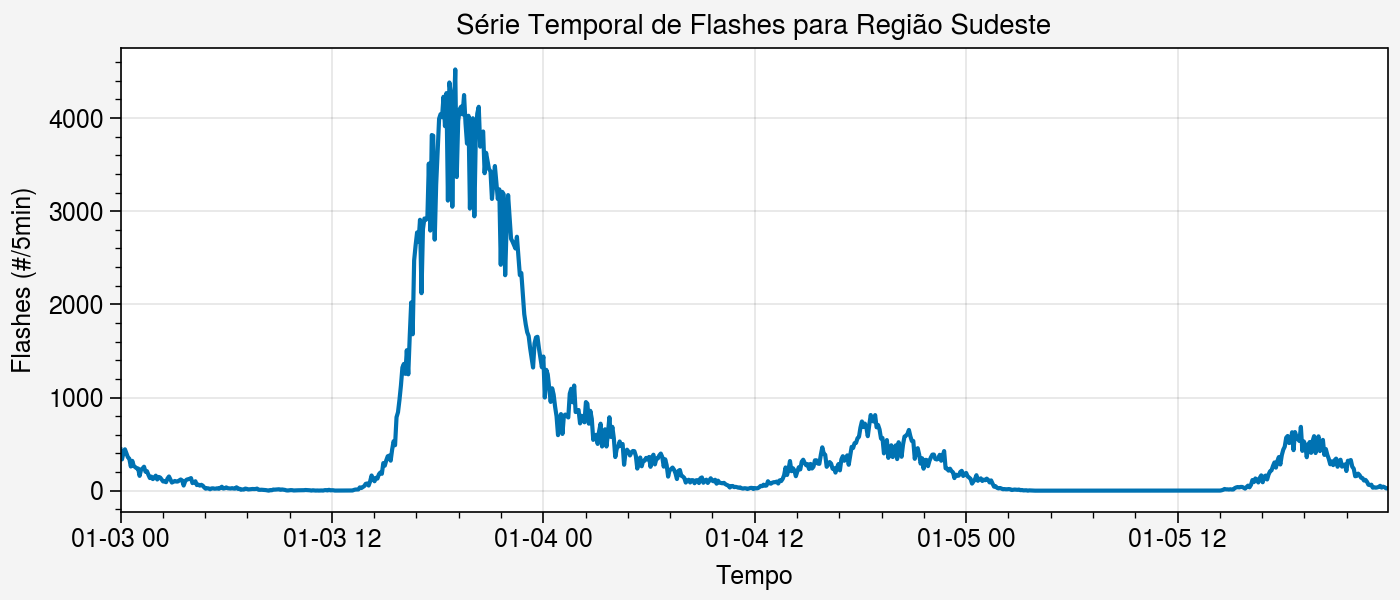

In [43]:
# cria moldura da figura
fig, ax = pplt.subplots(figsize=(7, 3), tight=True)

# plota figura
ax.plot(serie_temporal_5min['time'], serie_temporal_5min)

# formato dos eixos
ax.format(xlabel='Tempo', ylabel='Flashes (#/5min)',
          title='Série Temporal de Flashes para Região Sudeste',
          xrotation=0)

# salva figura
fig.save(f'{dir}output/parte_2/Fig_2_goes16_flash_serie_temporal_5min.jpg', dpi=300, bbox_inches='tight')

# exibe na tela a figura
pplt.show()

##**e) Reamostra o dado para escala "HORÁRIA"**

**Reamostra o dado**

In [44]:
# reamostra para escala horária
flash_hora = glm_5min['flash'].resample(time='1H').sum()

**Conhecendo os dados**

In [45]:
# mostra o dado horário que foi produzido
flash_hora

<xarray.DataArray 'flash' (time: 72, lat: 1664, lon: 1664)>
dask.array<stack, shape=(72, 1664, 1664), dtype=float32, chunksize=(1, 1664, 1664), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
  * time     (time) datetime64[ns] 2021-01-03 ... 2021-01-05T23:00:00
Attributes:
    units:                                                  flash/5minutes/64km2
    standard_name:                                          GLM Flash Centroi...
    valid_range:                                            [    0. 10000.]
    lat_field_of_view:                                      [ 66.56 -66.56]
    lon_field_of_view:                                      [ 66.56 -66.56]
    keywords:                                               lightning/goes/gl...
    FillValue:                                              0
    goes_imager_projection_longitude_of_projection_origin:  -89.5

In [46]:
# mostra os tempos
flash_hora['time'].values

array(['2021-01-03T00:00:00.000000000', '2021-01-03T01:00:00.000000000',
       '2021-01-03T02:00:00.000000000', '2021-01-03T03:00:00.000000000',
       '2021-01-03T04:00:00.000000000', '2021-01-03T05:00:00.000000000',
       '2021-01-03T06:00:00.000000000', '2021-01-03T07:00:00.000000000',
       '2021-01-03T08:00:00.000000000', '2021-01-03T09:00:00.000000000',
       '2021-01-03T10:00:00.000000000', '2021-01-03T11:00:00.000000000',
       '2021-01-03T12:00:00.000000000', '2021-01-03T13:00:00.000000000',
       '2021-01-03T14:00:00.000000000', '2021-01-03T15:00:00.000000000',
       '2021-01-03T16:00:00.000000000', '2021-01-03T17:00:00.000000000',
       '2021-01-03T18:00:00.000000000', '2021-01-03T19:00:00.000000000',
       '2021-01-03T20:00:00.000000000', '2021-01-03T21:00:00.000000000',
       '2021-01-03T22:00:00.000000000', '2021-01-03T23:00:00.000000000',
       '2021-01-04T00:00:00.000000000', '2021-01-04T01:00:00.000000000',
       '2021-01-04T02:00:00.000000000', '2021-01-04

In [47]:
# mostra a matriz quantidade de flashes às "17 horas do dia 3 de janeiro de 2021". Para isto usaremos a função "loc"
flash_hora.loc['2021-01-03T18:00:00.000000000'].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [48]:
# mostra o total de flashes da matriz às "17 horas do dia 3 de janeiro de 2021". Para isto usaremos a função "loc"
flash_hora.loc['2021-01-03T18:00:00.000000000'].sum().values

array(108517., dtype=float32)

**Produz um mapa simples da matriz de flash**

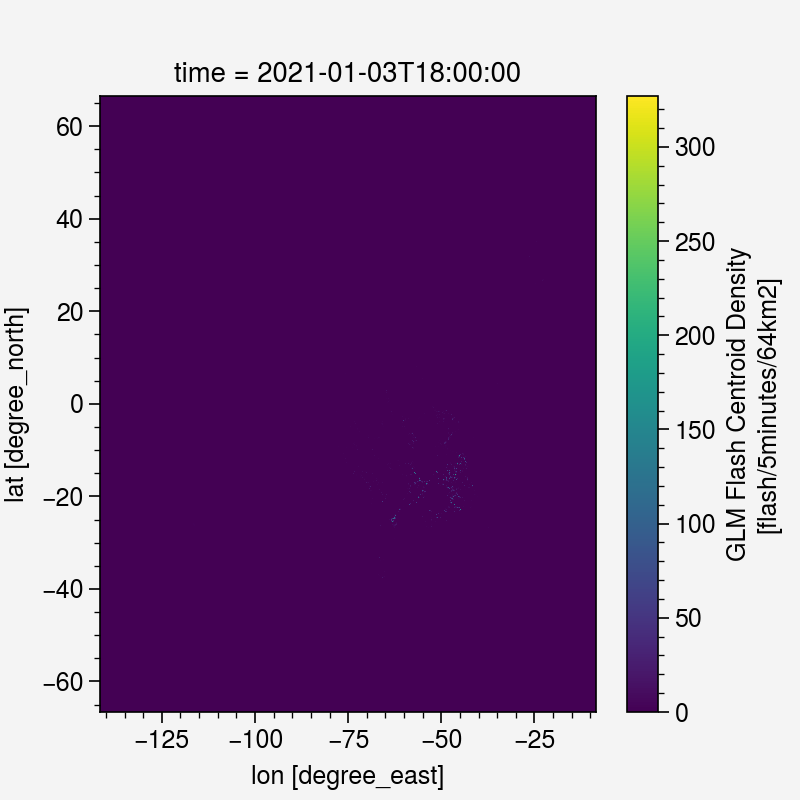

In [49]:
# produz um mapa simples da matriz de flash para ás "17 horas do dia 3 de janeiro de 2021"
flash_hora.loc['2021-01-03T18:00:00.000000000'].plot()

**Produz um mapa completo da matriz de flash**

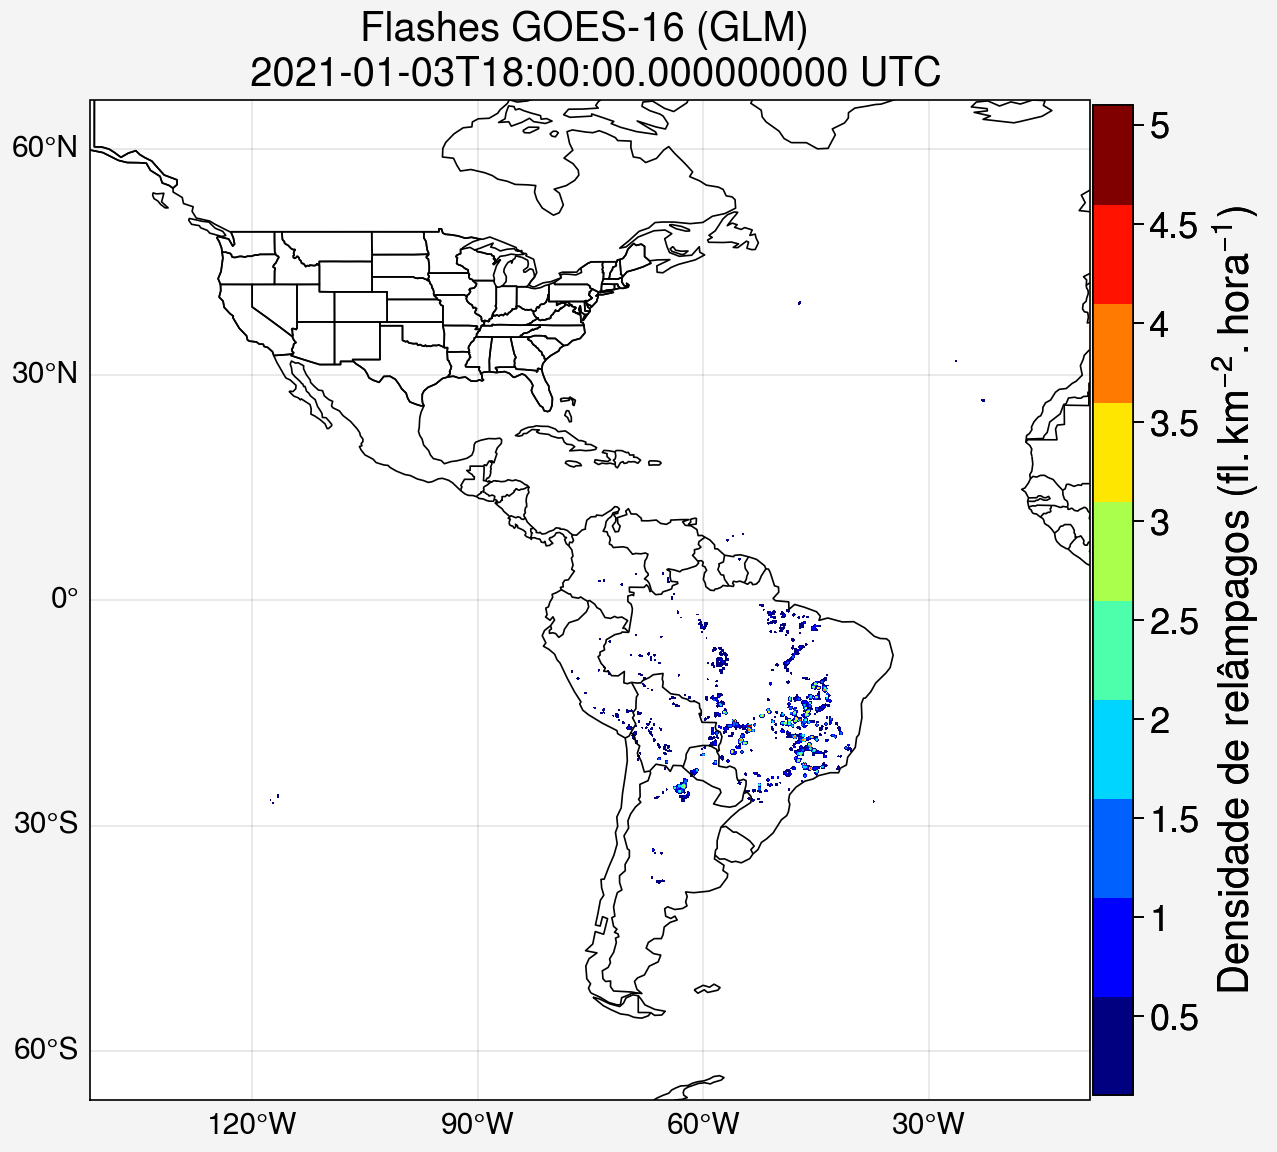

In [50]:
# define hora
hora = '18'
time = f'2021-01-03T{hora}:00:00.000000000'

# cria moldura da figura
fig, ax = pplt.subplots(axwidth=5, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=True, borders=True, innerborders=True,
          labels=True, latlines=30, lonlines=30,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) \n {time} UTC',
          small='15px', large='20px')

# plota mapa
map1 = ax.contourf(flash_hora['lon'],
                   flash_hora['lat'],
                   flash_hora.loc[time]/64.,
                   cmap='jet',
                   levels=pplt.arange(0.1, 5., 0.5))

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.hora^{-1})$',
             ticks=0.5, ticklabelsize=13, labelsize=15,
             space=0.1, length=0.99)

# salva figura
fig.save(f'{dir}output/parte_2/Fig_3_goes16_flash_mapa_hora.jpg', dpi=300)

**Produz gráfico com a série temporal de flash**

In [51]:
# fazendo a soma em área. Primeiro recortamos os dados para região Sudeste (função sel) e depois calculamos a média em área (mean(('lon', 'lat')))
serie_temporal_hora = flash_hora.sel(lon=slice(lonmin_rec, lonmax_rec), lat=slice(latmin_rec, latmax_rec)).sum(('lon', 'lat'))

In [52]:
# mostra a série temporal
serie_temporal_hora

<xarray.DataArray 'flash' (time: 72)>
dask.array<sum-aggregate, shape=(72,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-01-03 ... 2021-01-05T23:00:00

plota a série temporal

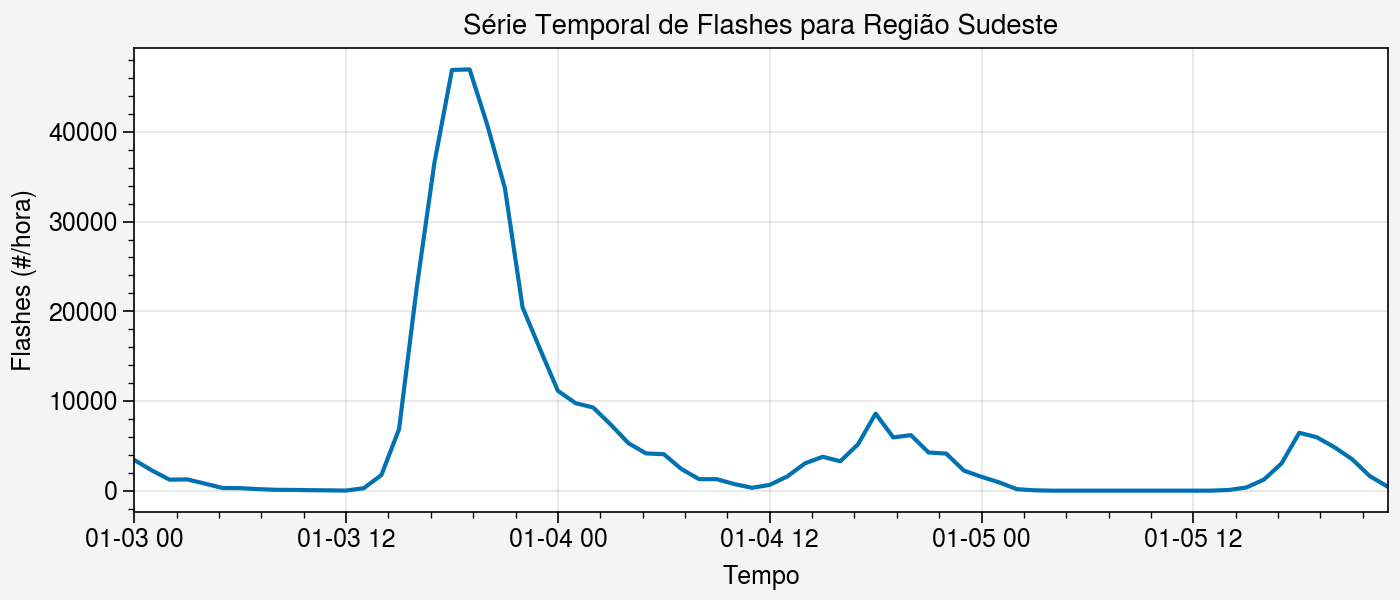

In [54]:
# cria moldura da figura
fig, ax = pplt.subplots(figsize=(7, 3), tight=True)

# plota fighura
ax.plot(serie_temporal_hora['time'], serie_temporal_hora)

# formato dos eixos
ax.format(xlabel='Tempo',
          ylabel='Flashes (#/hora)',
          title='Série Temporal de Flashes para Região Sudeste',
          xrotation=0)

# salva figura
fig.save(f'{dir}output/parte_2/Fig_4_goes16_flash_serie_temporal_hora.jpg', dpi=300, bbox_inches='tight')

# exibe na tela a figura
pplt.show()

##**f) Reamostra o dado para escala "DIÁRIA"**

**Reamostra o dado**

In [55]:
# reamostra para escala diária
flash_dia = glm_5min['flash'].resample(time='1D').sum()

**Conhecendo os dados**

In [56]:
# mostra o dado diário
flash_dia

<xarray.DataArray 'flash' (time: 3, lat: 1664, lon: 1664)>
dask.array<stack, shape=(3, 1664, 1664), dtype=float32, chunksize=(1, 1664, 1664), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
  * time     (time) datetime64[ns] 2021-01-03 2021-01-04 2021-01-05
Attributes:
    units:                                                  flash/5minutes/64km2
    standard_name:                                          GLM Flash Centroi...
    valid_range:                                            [    0. 10000.]
    lat_field_of_view:                                      [ 66.56 -66.56]
    lon_field_of_view:                                      [ 66.56 -66.56]
    keywords:                                               lightning/goes/gl...
    FillValue:                                              0
    goes_imager_projection_longitude_of_projection_origin:  -89.5

In [57]:
# mostra os tempos
flash_dia['time'].values

array(['2021-01-03T00:00:00.000000000', '2021-01-04T00:00:00.000000000',
       '2021-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [58]:
# mostra a matriz quantidade de flashes de um determinado dia. Para isto usaremos a função "loc"
flash_dia.loc['2021-01-03T00:00:00.000000000'].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
# mostra o total de flashes da matriz de um determinado dia. Para isto usaremos a função "loc"
flash_dia.loc['2021-01-03T00:00:00.000000000'].sum().values

array(981848., dtype=float32)

**Produz um mapa simples da matriz de flash**

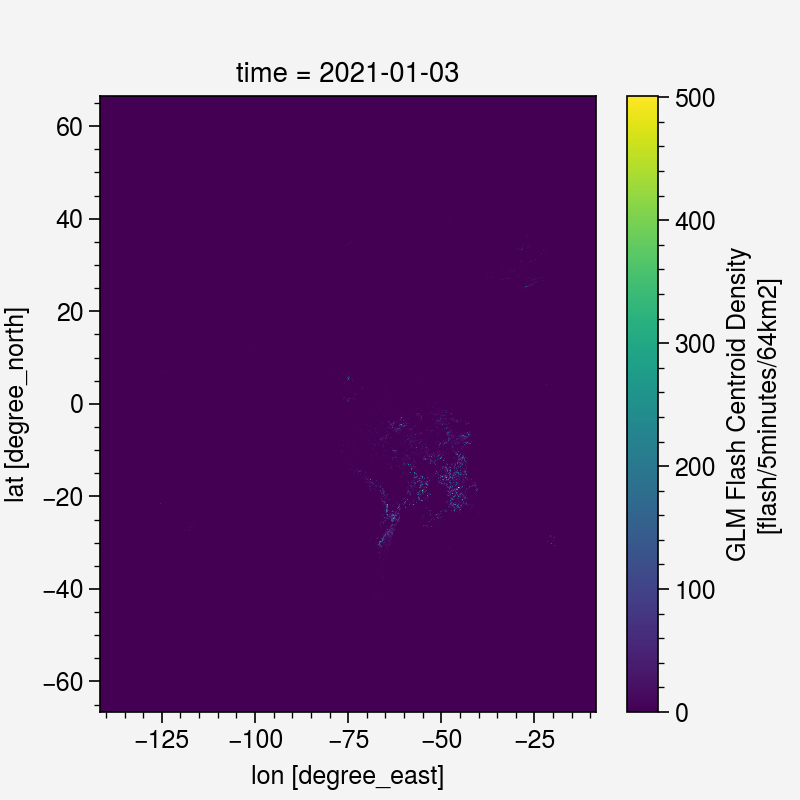

In [60]:
# faz um plot rápido para um determinado dia
flash_dia.loc['2021-01-03T00:00:00.000000000'].plot()

**Produz um mapa completo da matriz de flash**

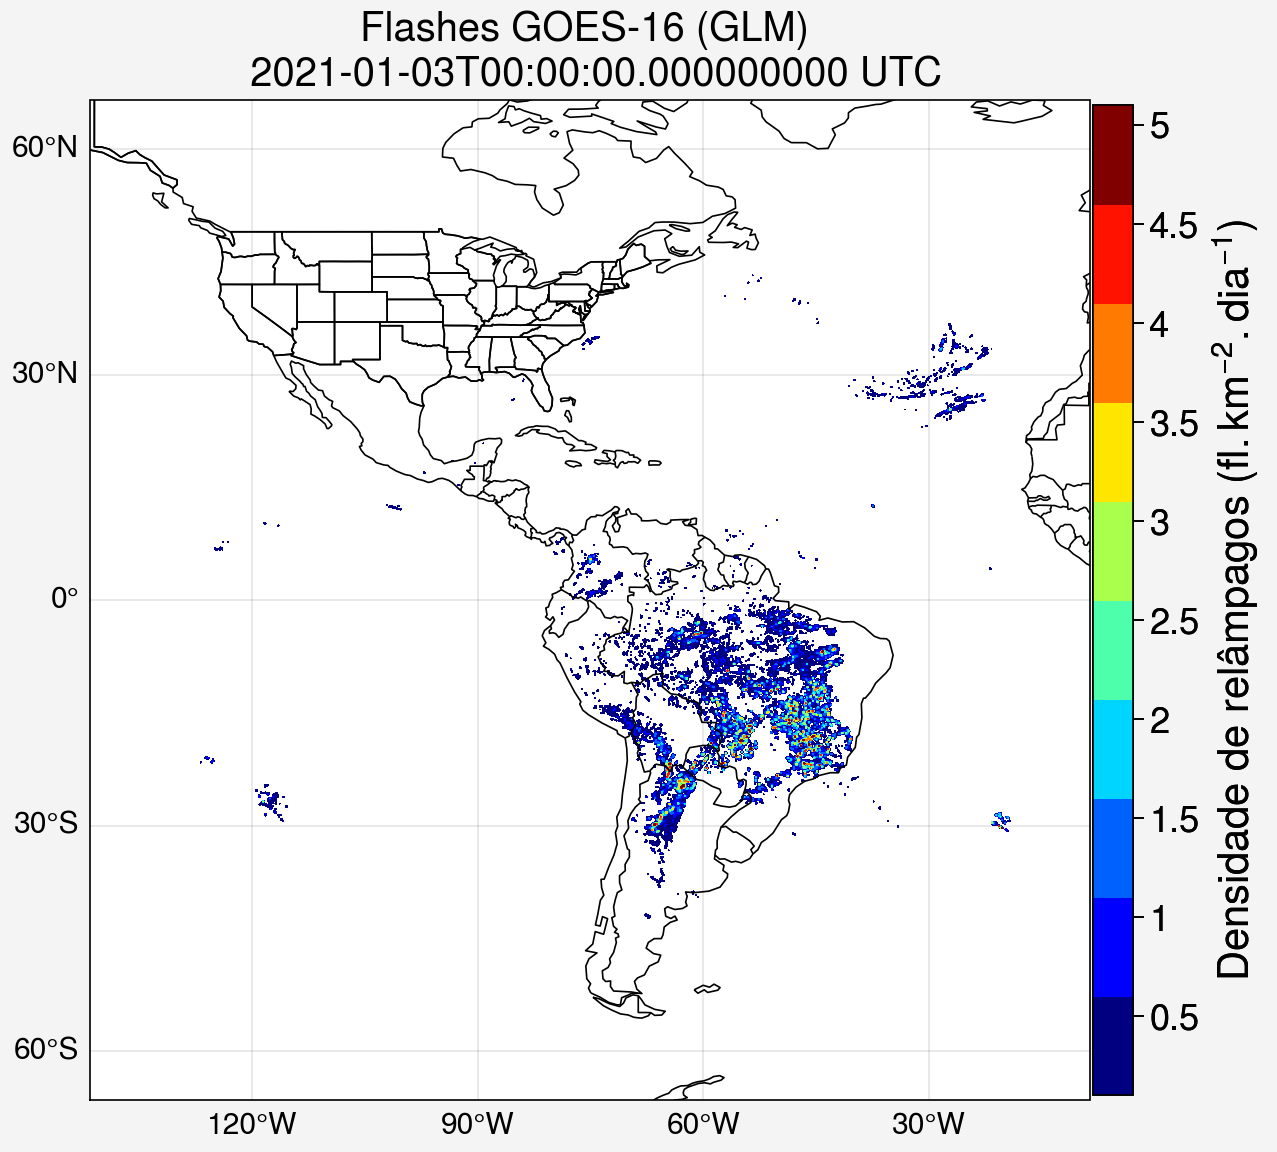

In [61]:
# define o dia
dia = '03'
time = f'2021-01-{dia}T00:00:00.000000000'

# cria moldura da figura
fig, ax = pplt.subplots(axwidth=5, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=True, borders=True, innerborders=True,
          labels=True, latlines=30, lonlines=30,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) \n {time} UTC',
          small='15px', large='20px')

# plota mapa
map1 = ax.contourf(flash_dia['lon'],
                   flash_dia['lat'],
                   flash_dia.loc[time]/64.,
                   cmap='jet',
                   levels=pplt.arange(0.1, 5., 0.5))

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.dia^{-1})$',
             ticks=0.5, ticklabelsize=13, labelsize=15,
             space=0.1, length=0.99)

# salva figura
fig.save(f'{dir}output/parte_2/Fig_5_goes16_flash_mapa_dia.jpg', dpi=300)

**Produz gráfico com a série temporal de flash**

In [62]:
# fazendo a soma em área. Primeiro recortamos os dados para região Sudeste (função sel) e depois calculamos a média em área (mean(('lon', 'lat')))
serie_temporal_dia = flash_dia.sel(lon=slice(lonmin_rec, lonmax_rec), lat=slice(latmin_rec, latmax_rec)).sum(('lon', 'lat'))

In [63]:
# mostra a série temporal
serie_temporal_dia

<xarray.DataArray 'flash' (time: 3)>
dask.array<sum-aggregate, shape=(3,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-01-03 2021-01-04 2021-01-05

plota a série temporal

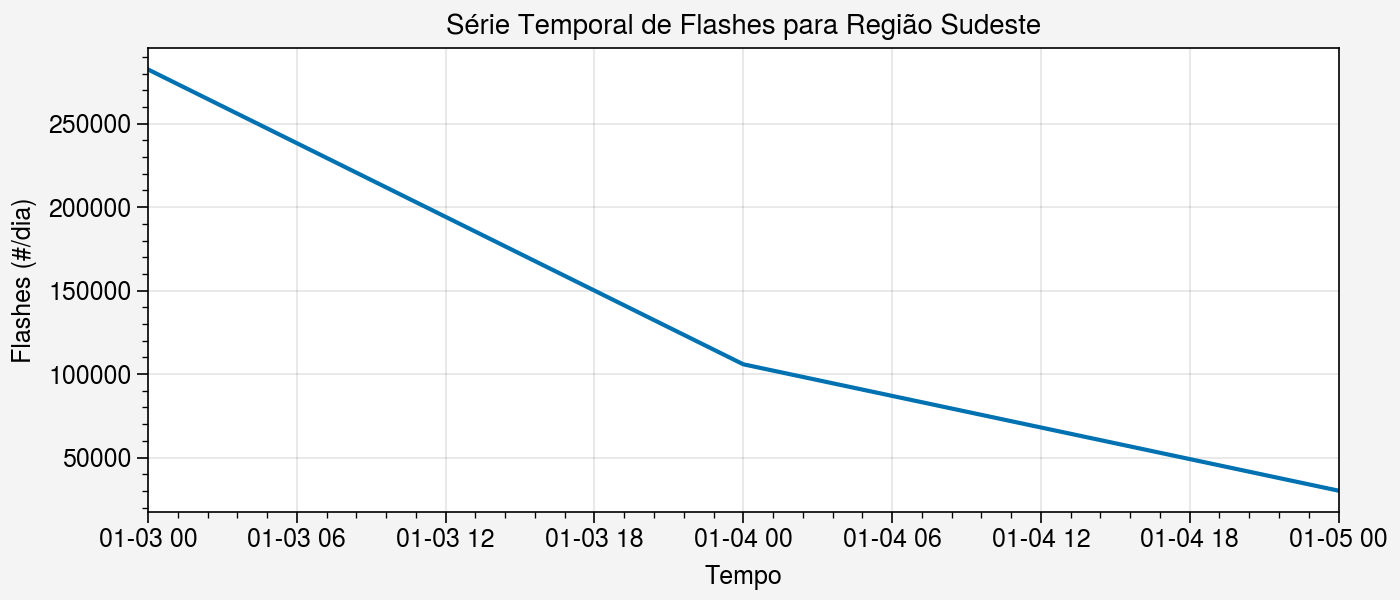

In [65]:
# cria moldura da figura
fig, ax = pplt.subplots(figsize=(7, 3), tight=True)

# plota fighura
ax.plot(serie_temporal_dia['time'], serie_temporal_dia)

# formato dos eixos
ax.format(xlabel='Tempo',
          ylabel='Flashes (#/dia)',
          title='Série Temporal de Flashes para Região Sudeste',
          xrotation=0)

# salva figura
fig.save(f'{dir}output/parte_2/Fig_6_goes16_flash_serie_temporal_dia.jpg', dpi=300, bbox_inches='tight')

# exibe na tela a figura
pplt.show()